In [5]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import subprocess

num_steps_users = 12  # Number of steps for users
num_steps_sizes = 12  # Number of steps for payload sizes
run_time_seconds = 60  # Number of seconds to run each test


In [6]:
payload_sizes = np.unique(np.logspace(0, 24, num=num_steps_sizes, base=2).astype(int))  # Logarithmically spaced sizes, ensure unique values
num_users_list = np.unique(np.logspace(0, 12, num=num_steps_users, base=2).astype(int))  # Logarithmically spaced users, ensure unique values

tasks = []
for payload_size in payload_sizes:
    for num_users in num_users_list:
        task = {
            "num_users": num_users,
            "spawn_rate": num_users,  # Adjust as needed
            "payload_size": payload_size,
            "csv_filename": f"results_{payload_size}_{num_users}"
        }
        tasks.append(task)

# View first 5 tasks as an example
tasks_df = pd.DataFrame(tasks)

pd.set_option('display.max_rows', None)
print(tasks_df)
pd.reset_option('display.max_rows')


     num_users  spawn_rate  payload_size           csv_filename
0            1           1             1            results_1_1
1            2           2             1            results_1_2
2            4           4             1            results_1_4
3            9           9             1            results_1_9
4           20          20             1           results_1_20
5           43          43             1           results_1_43
6           93          93             1           results_1_93
7          198         198             1          results_1_198
8          423         423             1          results_1_423
9          902         902             1          results_1_902
10        1922        1922             1         results_1_1922
11        4096        4096             1         results_1_4096
12           1           1             4            results_4_1
13           2           2             4            results_4_2
14           4           4             4

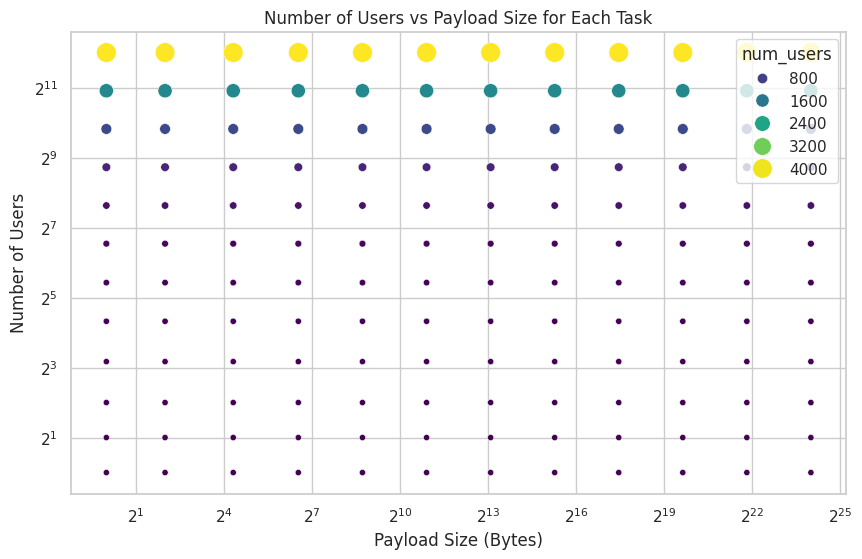

In [7]:
# Set the aesthetics for the plot
sns.set(style="whitegrid")

# Create the scatter plot
plt.figure(figsize=(10, 6))
ax = sns.scatterplot(data=tasks_df, x='payload_size', y='num_users', size='num_users', hue='num_users', palette='viridis', sizes=(20, 200))

# Set the scale of the x/y-axis to logarithmic to better visualize the data
ax.set_xscale('log', base=2)
ax.set_yscale('log', base=2)

# Set plot labels and title
ax.set_xlabel('Payload Size (Bytes)')
ax.set_ylabel('Number of Users')
ax.set_title('Number of Users vs Payload Size for Each Task')

# Show the plot
plt.show()

In [ ]:
def run_benchmark(task):
    results_file_path = f"results/{task['csv_filename']}"

    # Check if the results file already exists
    if os.path.exists(f"{results_file_path}_stats.csv"):
        print(f"Skipping benchmark for task: {task} as results already exist.")
        return
    
    # Set environment variables
    os.environ['NUM_USERS'] = str(task['num_users'])
    os.environ['SPAWN_RATE'] = str(task['spawn_rate'])
    os.environ['RUN_TIME'] = str(run_time_seconds)
    os.environ['CSV_FILENAME'] = results_file_path
    os.environ['PAYLOAD_SIZE'] = str(task['payload_size'])
    
    # Ensure the results directory exists
    os.makedirs('.results', exist_ok=True)
    
    # Run the benchmark using Docker Compose
    subprocess.run(["docker", "compose", "up", "--scale", "locust-worker=4"], check=True)

    # Optionally, you can stop and remove containers if needed
    subprocess.run(["docker-compose", "down"], check=True)

for task in tasks:
    run_benchmark(task)


In [10]:
results = []
for task in tasks:
    csv_filename = f".results/{task['csv_filename']}_stats.csv"
    try:
        df = pd.read_csv(csv_filename)
        if not df.empty:
            agg_row = df.iloc[-1]  # Select the last row
            if agg_row["Name"] == "Aggregated":
                results.append({
                    "payload_size": task["payload_size"],
                    "num_users": task["num_users"],
                    "total_requests": int(agg_row["Request Count"]),
                    "avg_response_time": float(agg_row["Average Response Time"]),
                })
            else:
                print(f"No aggregated data found in {csv_filename}")
        else:
            print(f"The CSV file is empty: {csv_filename}")
    except FileNotFoundError:
        print(f"Results not found for task: {task}")
    except Exception as e:
        print(f"An error occurred for task {task}: {str(e)}")

results_df = pd.DataFrame(results)
pd.set_option('display.max_rows', None)
print(results_df)
pd.reset_option('display.max_rows')


    payload_size  num_users  total_requests  avg_response_time
0              1         10           21285          27.546300
1              1         16           21149          44.671521
2              1         27           20596          77.818314
3              1         46           20291         134.226159
4              1         77           20175         219.238265
5              1        129           20121         361.084290
6              1        215           20169         556.397987
7              1        359           19775         751.576839
8              1        599           19629        1270.587141
9              1       1000           19169        2218.573269
10             5         10           21175          27.644392
11             5         16           21175          44.650815
12             5         27           20460          78.354888
13             5         46           20116         136.066962
14             5         77           19991         223

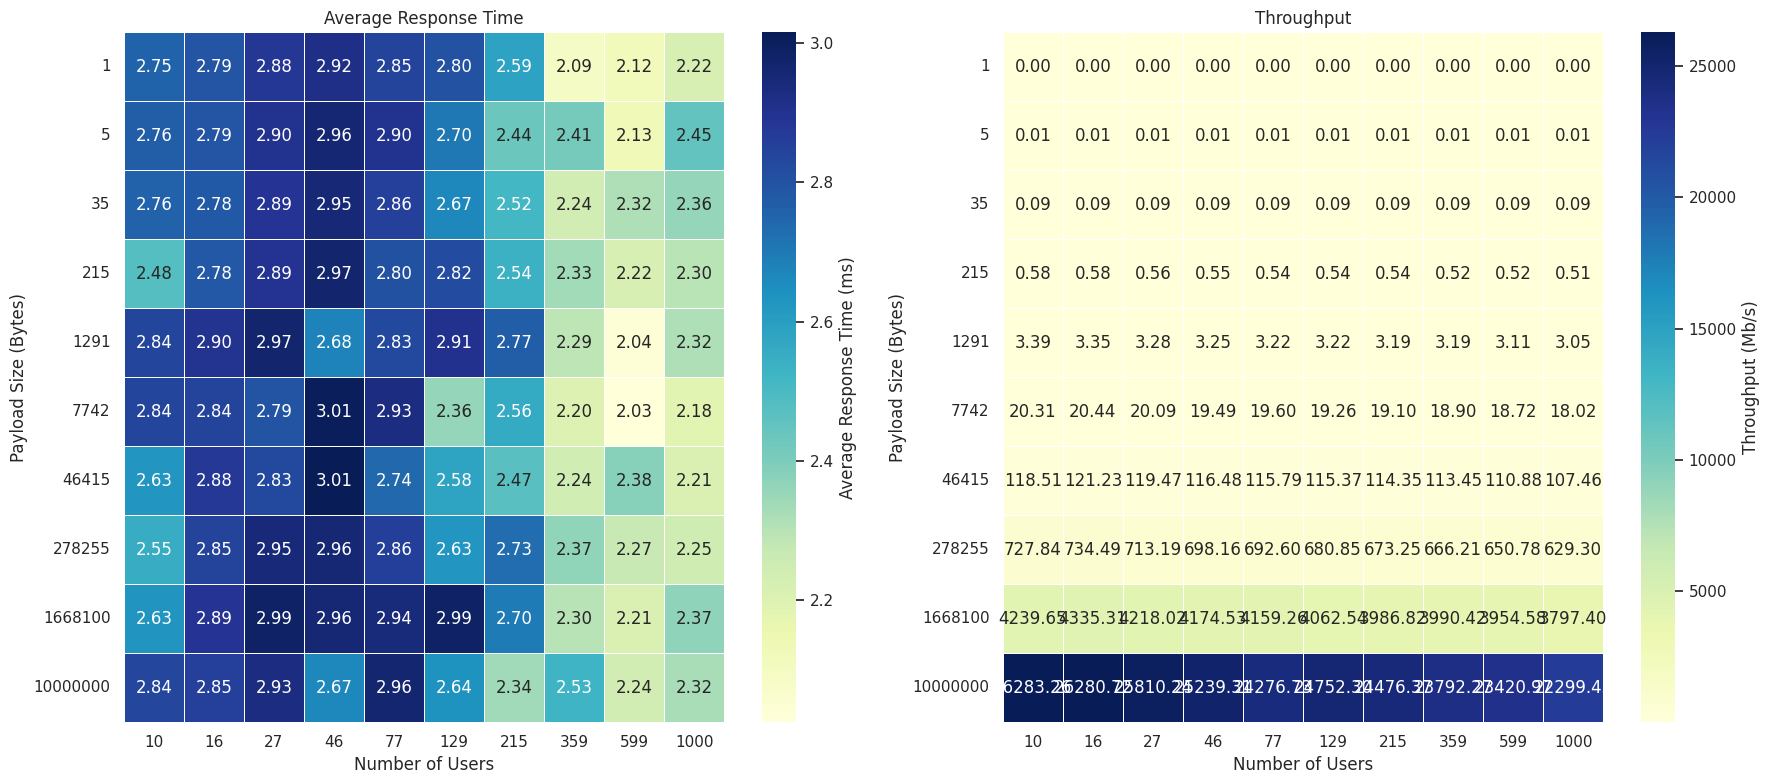

In [8]:
# Add columns for requests per second and requests per second per user
results_df['requests_per_second'] = results_df['total_requests'] / run_time_seconds
results_df['throughput'] = results_df['requests_per_second'] * results_df['payload_size'] * 8 / 1024 / 1024  # Megabits per second

# Pivot the DataFrames for the heatmaps
heatmap_data_rps = results_df.pivot(index="payload_size", columns="num_users", values="throughput")
heatmap_data_rt = results_df.pivot(index="payload_size", columns="num_users", values="avg_response_time")

# Set up the matplotlib figure
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))

# Draw the heatmap for average response time
sns.heatmap(heatmap_data_rt, cmap="YlGnBu", annot=True, fmt=".2f", linewidths=.5, cbar_kws={"label": "Average Response Time (ms)"}, ax=axes[0])
axes[0].set_title('Average Response Time')
axes[0].set_xlabel('Number of Users')
axes[0].set_ylabel('Payload Size (Bytes)')

# Draw the heatmap for requests per second per user
sns.heatmap(heatmap_data_rps, cmap="YlGnBu", annot=True, fmt=".2f", linewidths=.5, cbar_kws={"label": "Throughput (Mb/s)"}, ax=axes[1])
axes[1].set_title('Throughput')
axes[1].set_xlabel('Number of Users')
axes[1].set_ylabel('Payload Size (Bytes)')

plt.tight_layout()
plt.show()
